In [1]:
import re
import csv
import collections
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.colors
from scipy.spatial import cKDTree as KDTree
import geopandas as gpd
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

# To print data in tabular format
from tabulate import tabulate
import json

#Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [2]:
#------------------------------------------------------------------------------
class GeocodeData:

    def __init__(self):
        coordinates, self.locations = self.extract()
        self.tree = KDTree(coordinates)
        self.load_countries()
  

    def load_countries(self):
        """Load a map of country code to name
        """
        self.countries = {}
        for code, name in csv.reader(open('./countries.csv')):
            self.countries[code] = name


    def query(self, coordinates):
        """Find closest match to this list of coordinates
        """
        try:
            distances, indices = self.tree.query(coordinates, k=1)
        except ValueError as e:
            print('Unable to parse coordinates: {}'.format(coordinates))
            raise e
        else:
            results = [self.locations[index] for index in indices]
            for result in results:
                result['country'] = self.countries.get(result['country_code'], '')
            return results


    def extract(self):
        """Extract geocode data 
        """

        rows = pd.read_csv('./geocode.csv')

        # load a list of known coordinates and corresponding locations
        coordinates, locations = [], []        
        
        for index, row in rows.iterrows():
            coordinates.append((row['Latitude'], row['Longitude']))
            locations.append(dict(country_code=row['CountryCode'], city=row['City']))
        return coordinates, locations
        
#------------------------------------------------------------------------------

### Class GeocodeData
------
* This Class has different methods which are going to be useful in this project later.


* This Class's methods help us identify the cities and the countries where the earthquakes occurred by providing us with the coordinates.


* Simply this class will give the Cities' and Countries' names if the respective coordinates are passed.



In [3]:
def earthquakeFileRead():
    """Extract earthquakeFile data 
    """

    rows = pd.read_csv("earthquakes-23k.csv")

    # load a list of known coordinates and corresponding locations
    coordinates = []        
    dates = []
    magnitude = []
    
    for index, row in rows.iterrows():
        coordinates.append((row['Latitude'], row['Longitude']))
        dates.append(row['Date'])
        magnitude.append(row['Magnitude'])
        
    return coordinates, dates, magnitude        

  
def get(coordinate):
    """Search for closest known location to this coordinate
    """
    gd = GeocodeData()
    return gd.query([coordinate])[0]

def search(coordinates):
    """Search for closest known locations to these coordinates
    """
    gd = GeocodeData()
    return gd.query(coordinates)

def state_plotter(states, us_map=True):
    """Plot the data on USA map
    """
    usa = gpd.read_file('./maps/states.shp')
    fig, ax = plt.subplots(figsize=(10,10))
    if us_map:
        
        if 'HI' in states:
            usa[0:50].plot(ax=ax, alpha = 0.3)
        elif 'AK' in states:
            usa[1:51].plot(ax=ax, alpha = 0.3)
        elif 'HI' and 'AK' in states:
            usa[0:51].plot(ax=ax, alpha = 0.3)
        else:
            usa[1:50].plot(ax=ax, alpha = 0.3)
            
        for n in states:
            usa[usa.STATE_ABBR == f'{n}'].plot(ax=ax, edgecolor='y', linewidth=2, legend=True)


        plt.title('Earthquakes by States')
            
    elif us_map == False:
        for n in states:
            usa[usa.STATE_ABBR == f'{n}'].plot(ax=ax, edgecolor='y', linewidth=2, legend=True)
            plt.title('Earthquakes by States')
            
            

'''
Get a list of keys from dictionary which has the given value
'''
def getKeysByValue(valueToFind):
    global st
    reObj = re.compile(str(valueToFind))
    for k, v in st.states.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if(reObj.match(v)):
            return k


* I'm  going to use different CSV files. One is the main raw data file which contains coordinates of the earthquakes which has occurred since 1965, with its magnitudes.


* After that I'm going to use another CSV file which has the coordinates of the different cities in the world along with their respective country codes.


* Then finally we have our country csv file which contains country code along with countries' names.

----

Then I will pass all the coordinates from the main file and I will get the city and country's name which were affected by the earthquakes.

In [4]:
lat_long, dates, magnitude = earthquakeFileRead()

# test some coordinate lookups
#city1 = 19.246,145.616

datas = search(lat_long)

#update the earthquake data with dates and magnitude
for uD, dt, mg in zip(datas, dates, magnitude):
    dict1 = {'date':dt, 'magnitude':mg} 
    uD.update(dict1)

counter=0

header = datas[0].keys()
rows=[]
for x in datas:
    rows.append(x.values())
    
    counter+=1
    if counter==20:
        break
        
        
print(tabulate(rows, header,tablefmt='grid'))

+----------------+-----------------------+----------------------------------------------+------------+-------------+
| country_code   | city                  | country                                      | date       |   magnitude |
+================+=======================+==============================================+============+=============+
| MP             | Saipan                | Northern Mariana Islands                     | 12/21/2016 |         5.9 |
+----------------+-----------------------+----------------------------------------------+------------+-------------+
| ID             | Tongutisungi          | Indonesia                                    | 10/09/2016 |         5.8 |
+----------------+-----------------------+----------------------------------------------+------------+-------------+
| TO             | Pangai                | Tonga                                        | 11/16/2016 |         5.8 |
+----------------+-----------------------+----------------------

Note: Only 20 rows are displayed.


* Now I have grouped all the neccessary data together.


* I have grouped all the earthquakes data such that we understand which city of which country was affected by the earthquakes by what intensity and on which date.

In [5]:
'''
Data for pie graph

CLASS	     MAGNITUDE
----------------------
Great	     8 or more
Major	     7 - 7.9
Strong	     6 - 6.9
Moderate	 5 - 5.9
Light	     4 - 4.9
Minor	     3 -3.9


Now, I'll group the data according to the magnitude of the earthquakes.
'''
uniqueDataByMagnitude  = collections.Counter(e['magnitude'] for e in datas)

print(json.dumps(uniqueDataByMagnitude, indent=2,sort_keys=True ))


{
  "5.5": 5568,
  "5.51": 2,
  "5.52": 12,
  "5.58": 2,
  "5.6": 5071,
  "5.66": 2,
  "5.67": 1,
  "5.69": 4,
  "5.7": 2176,
  "5.72": 1,
  "5.75": 2,
  "5.77": 3,
  "5.8": 2519,
  "5.89": 1,
  "5.9": 2385,
  "5.94": 1,
  "5.97": 1,
  "6.0": 1337,
  "6.02": 1,
  "6.1": 1182,
  "6.2": 495,
  "6.3": 411,
  "6.35": 1,
  "6.4": 571,
  "6.5": 246,
  "6.6": 265,
  "6.7": 600,
  "6.8": 220,
  "6.9": 87,
  "7.0": 79,
  "7.1": 32,
  "7.2": 50,
  "7.3": 37,
  "7.4": 7,
  "7.5": 14,
  "7.6": 12,
  "7.7": 8,
  "7.8": 1,
  "7.9": 2,
  "8.0": 2,
  "8.2": 1
}


* I am grouping the earthquakes data according to its class. This will be helpful for the Pie Graph.


* Then I'll group the data according to the Earthquake's Class.

In [6]:
Great=0
Major=0
Strong=0
Moderate=0
Light=0
Minor=0

for key, value in uniqueDataByMagnitude.items() :
    key = int(key)
    if key>=8:
        Great+=value
    elif key >=7 and key <8:
        Major+=value
    elif key >=6 and key <7:
        Strong+=value
    elif key >=5 and key <6:
        Moderate+=value
    elif key >=4 and key <5:
        Light+=value
    elif key >=3 and key <4:
        Minor+=value


print('Great: ',Great,'\nMajor: ',Major,'\nStrong: ',Strong,'\nModerate: ',Moderate,'\nLight: ',Light,'\nMinor: ',Minor)

Great:  3 
Major:  242 
Strong:  5416 
Moderate:  17751 
Light:  0 
Minor:  0


* From this data it's clear that earthquakes of Class Moderate has hit the earth the most during the selected time period. The Pie Chart allows me to visualize the data better.

Text(0.5, 1, 'Eartquakes From 1965 - 2016 by Classes')

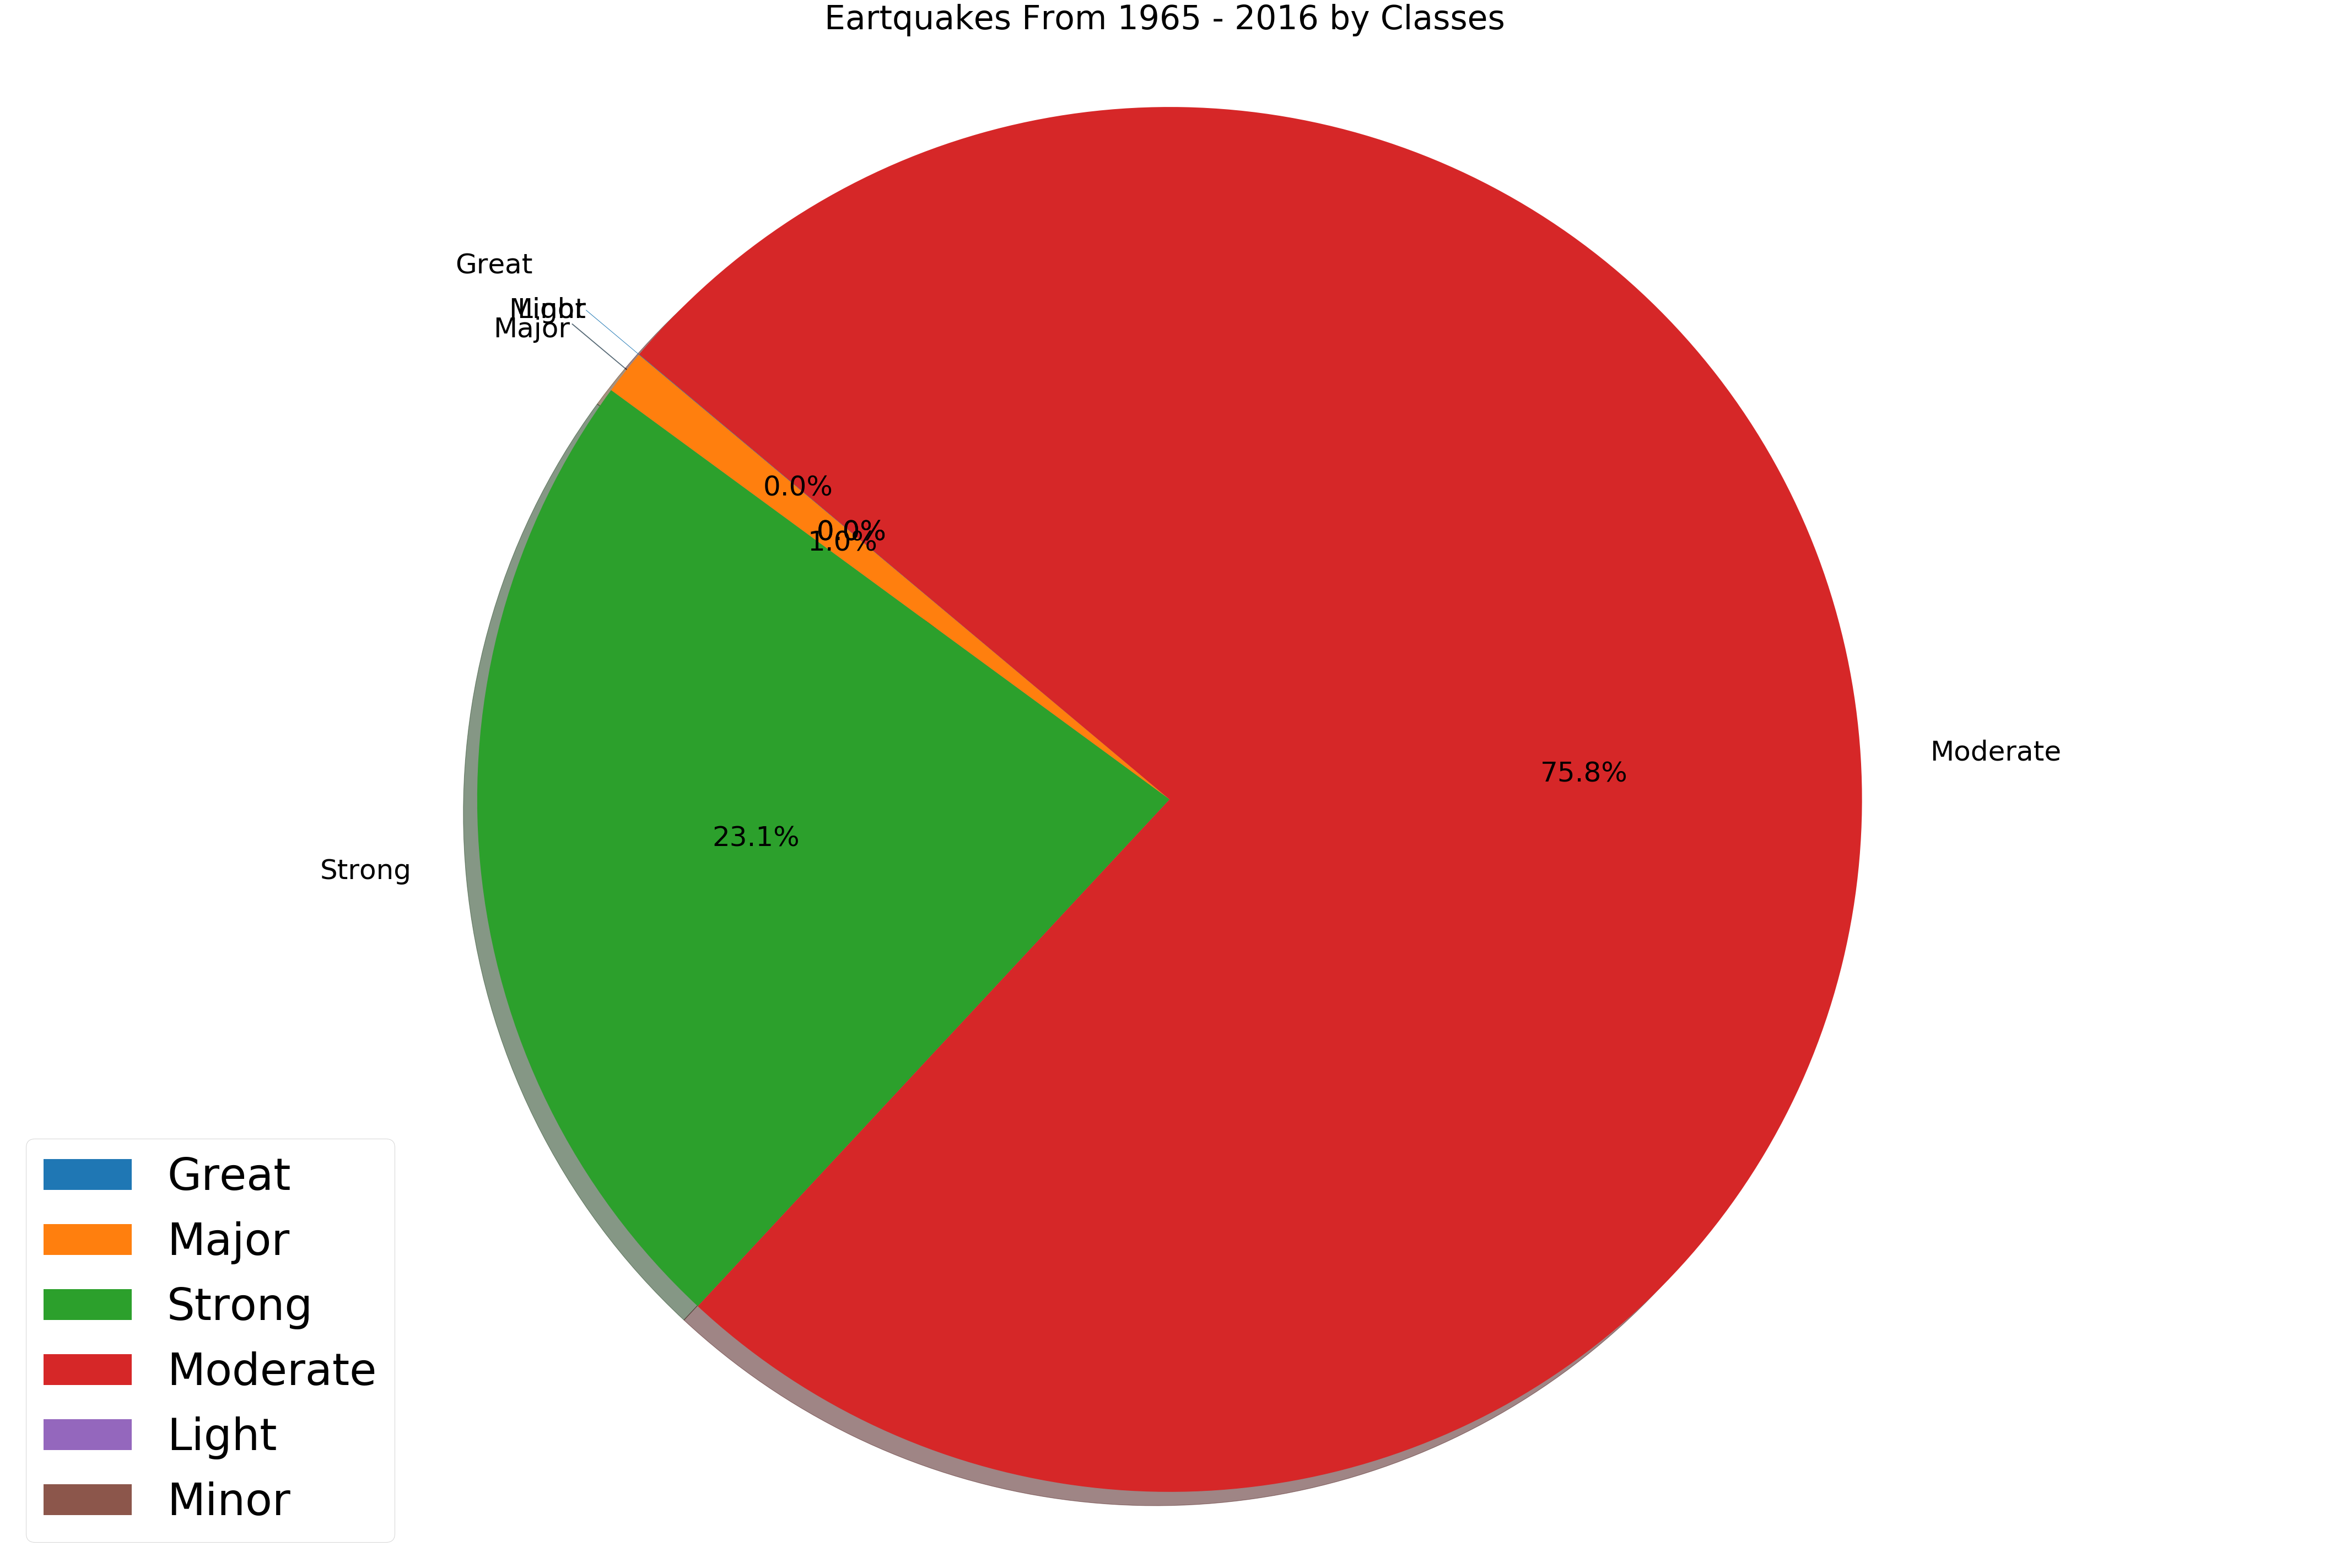

In [7]:
'''        
# Plotting Pie graph
'''

# Data to plot
#plt.subplot(211)
plt.figure(figsize=(60, 40))
plt.rcParams['font.size'] = 50.0
labels = ['Great', 'Major', 'Strong', 'Moderate', 'Light', 'Minor']
sizes = [Great, Major, Strong, Moderate, Light, Minor]
colors = ['red ', 'orange', 'brown', 'yellow', 'purple' ,'blue' ]
explode = (0.1, 0, 0, 0, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels,  autopct='%1.1f%%', shadow=True, startangle=140)
plt.legend(labels,loc=3, prop={'size': 80})
plt.axis('equal')
plt.tight_layout()
plt.title('Eartquakes From 1965 - 2016 by Classes')

* Now I'm goinng to plot a bar graph which shows number of earthquakes which had hit the different countries during the time period of 1965-2016.


* On the X-axis we have the 'Countries' names' and on Y-axis we have the 'Number of earthquakes'

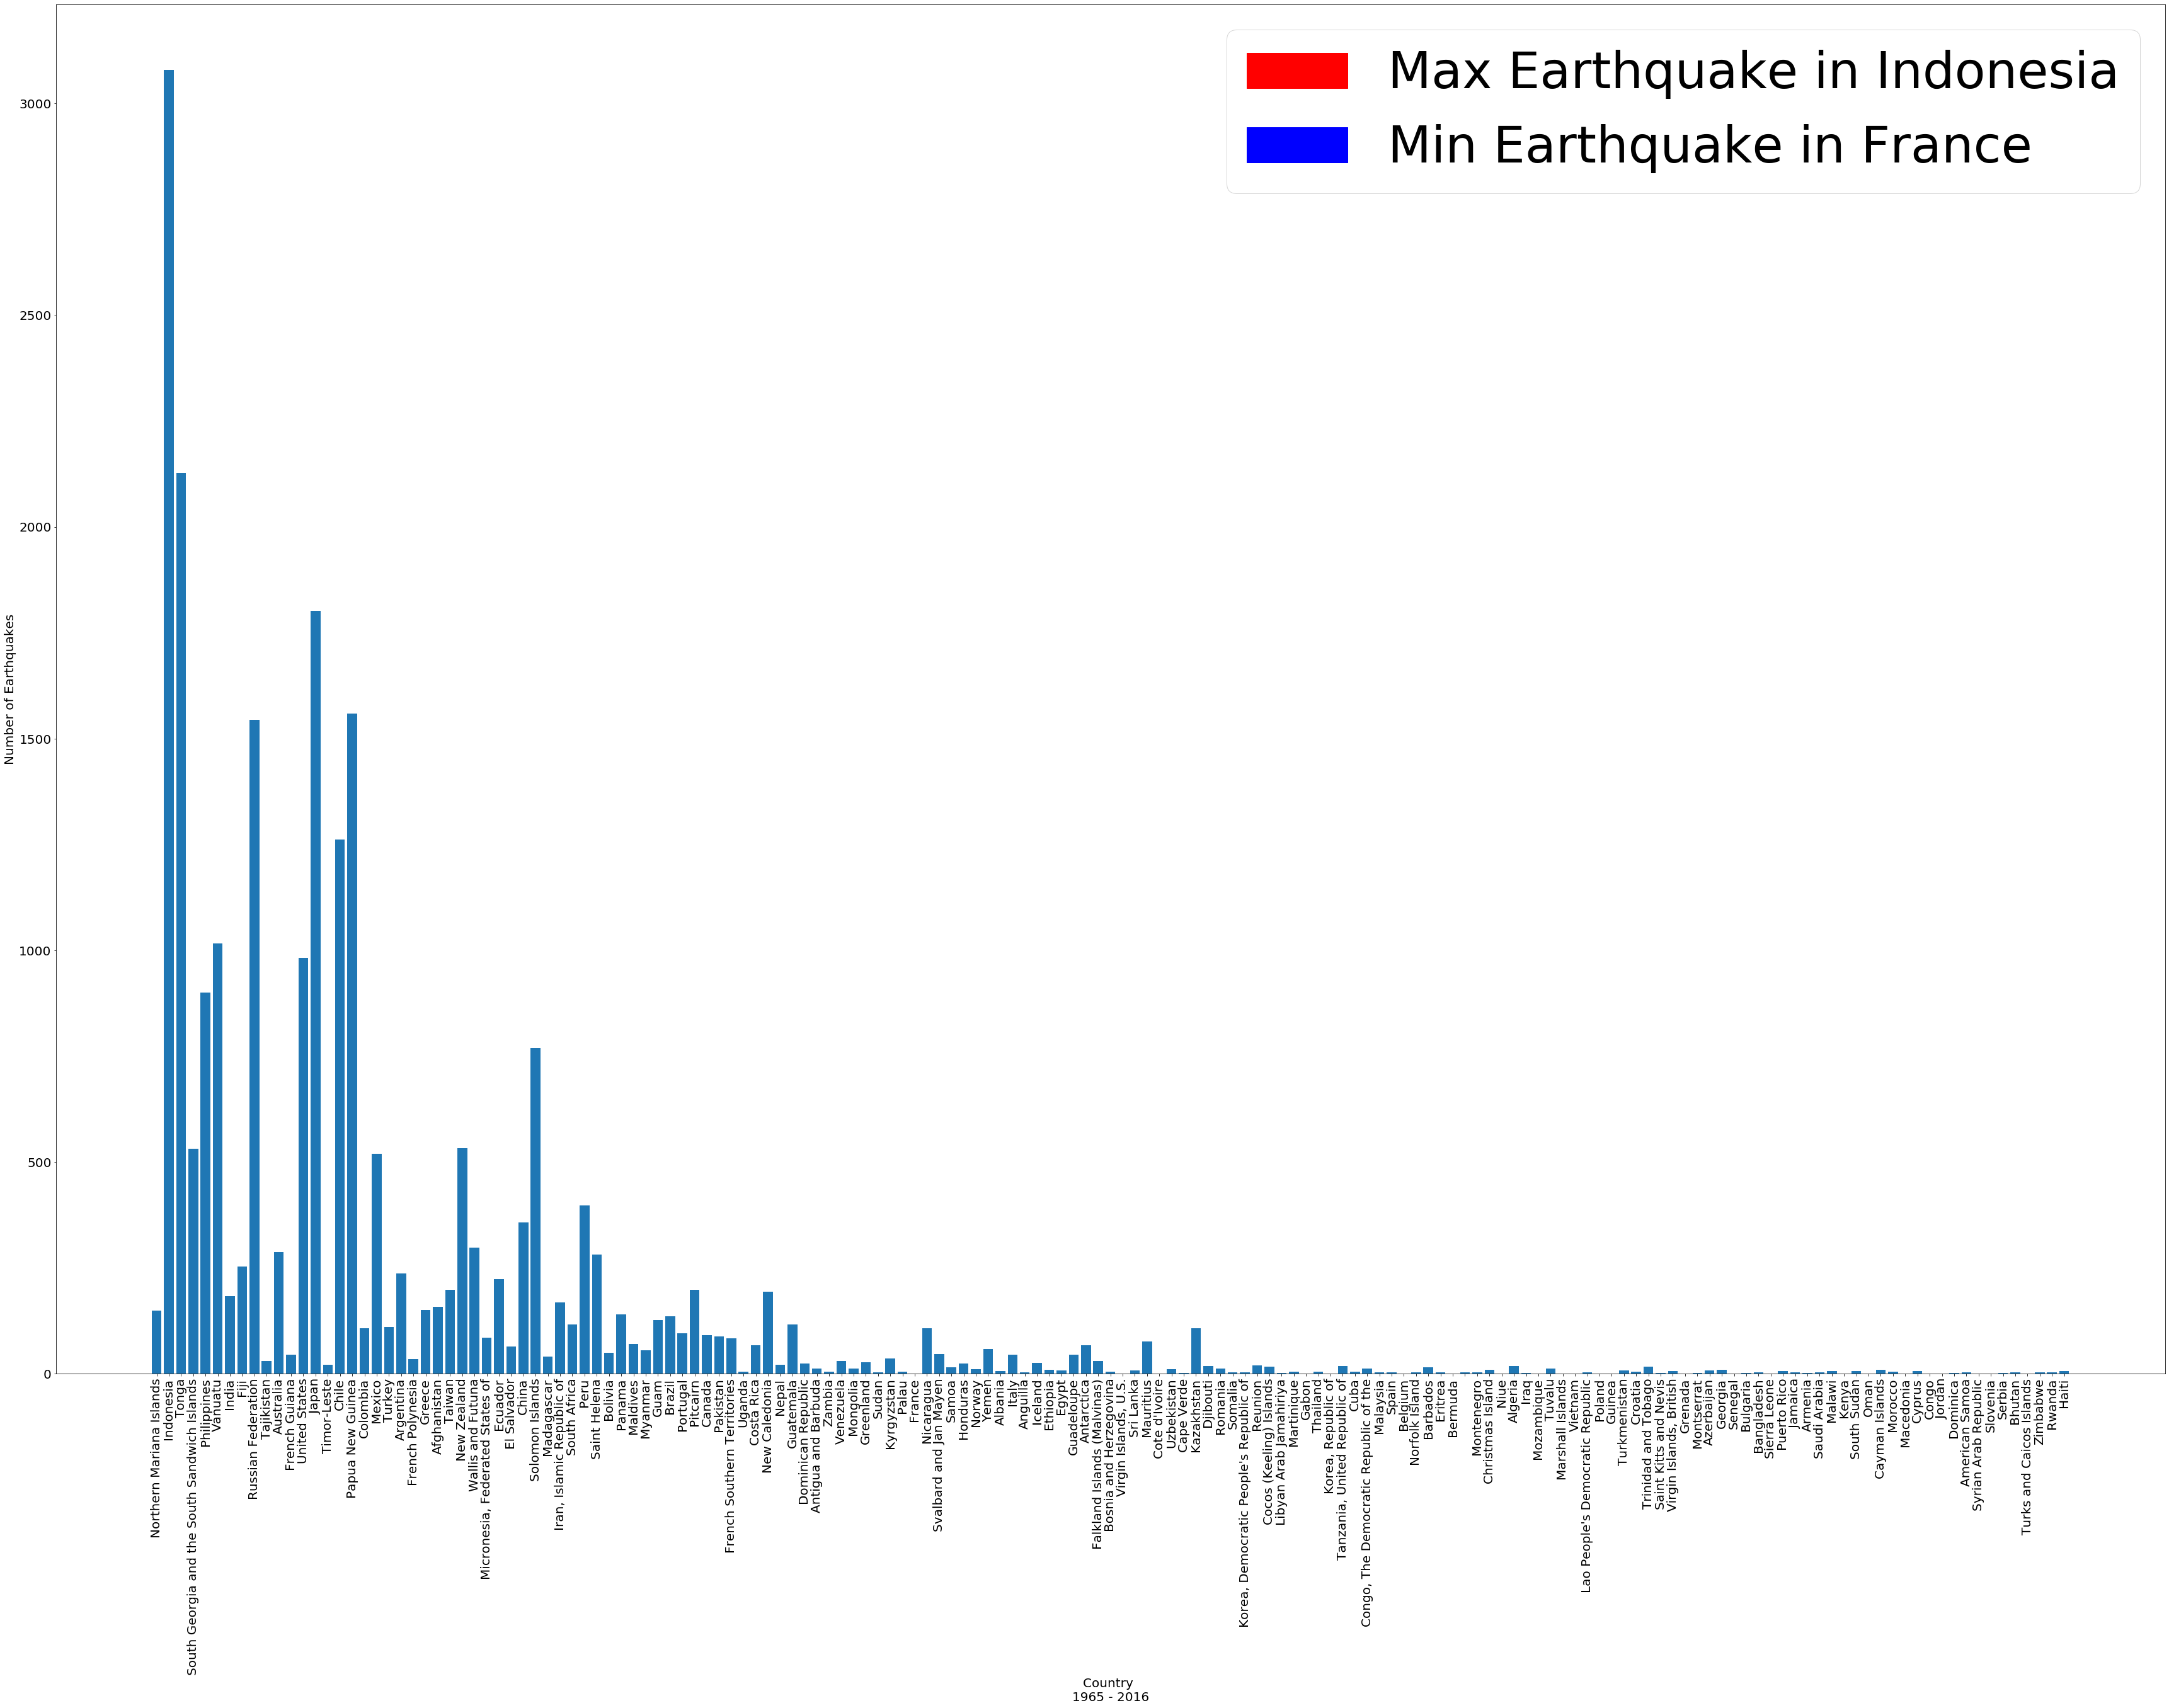

In [8]:
'''        
# Plotting bar graph
'''
#plt.subplot(212)
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.size'] = 20.0
plt.figure(figsize=(60, 40))
uniqueData  = collections.Counter(e['country'] for e in datas)

max_eq = max(uniqueData, key=uniqueData.get)
min_eq = min(uniqueData, key=uniqueData.get)

plt.bar(range(len(uniqueData)), list(uniqueData.values()), align='center')
plt.xticks(range(len(uniqueData)), list(uniqueData.keys()), rotation=90)
plt.xlabel('Country \n1965 - 2016')
plt.ylabel('Number of Earthquakes')

red_patch = mpatches.Patch(color='red', label='Max Earthquake in '+max_eq)
blue_patch = mpatches.Patch(color='blue', label='Min Earthquake in '+min_eq)

plt.legend(handles=[red_patch, blue_patch], prop={'size': 80})

plt.show()

* The above graph helps to visualize the earthquake's data country-wise and also shows which country was hit by the maximum number of earthquakes and which was hit by the minimum number.

* It is clear that Indonesia have been hit by the maximum number of earthquakes and France by the minimum number.
---

Now my aim is to show the number earthquakes happend in USA, State-wise on the USA map.

{
  "null": 928,
  "CA": 16,
  "AK": 2,
  "MI": 26,
  "IL": 4,
  "CT": 1,
  "OR": 4,
  "TX": 1
}


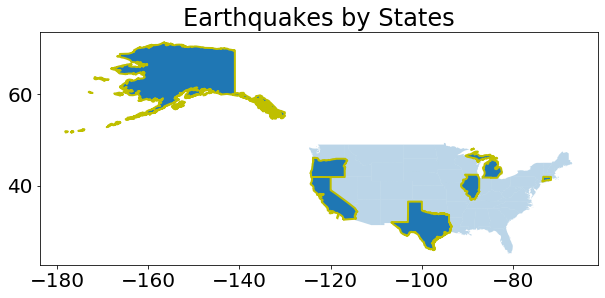

In [9]:
import states as st
'''
It contains two dictionary:

states : which contains state's code along with name.

city_to_state_dict : which contains almost all city name along with the state's code

------------------------------------------------------------------------------------
First I'll get the data where the country code is USA.

Then I'm going to map the city of earthquakes state-wise on the USA map.

'''

USA_states = []
for dt in datas:
    if dt['country_code'] == 'US':
        dict1 = {'state_code': getKeysByValue(st.city_to_state_dict.get(dt['city']))}
        dt.update(dict1)
        USA_states.append(dt)

USA_states_uniqueData  = collections.Counter(e['state_code'] for e in USA_states)

print(json.dumps(USA_states_uniqueData, indent=2 ))
state_plotter(USA_states_uniqueData.keys())

* Now we can see the the states on USA map where earthquake occurred from 1965. In the dataset I also have NULL values because I don't have complete set of cities name, for example from Alaska. The null set mostly contains cities which are in Alaska.
---

## Summary
I took three dataset(CSV files) from different sources. My aim was to group the the different dataset to get meaningful result.

* First I took my main file which contains coordinates of the earthquakes along with its magnitude and with date which happened from 1965 to 2016.

* Then I took different CSV file which contains almost all the cities' name in the world with their coordinates and Country code.

* And finally the last CSV file with country code with Country name.

* Then, I passed the coordinates from earthquake file in the object of GeocodeData class, which found its closest match to this list of coordinates and gave me the city name and country code. Then from the country code I got the country's name.

* Storing all the data in a list of dictionary.

* Then I've grouped the data according to the earthquake's classes and the plotted Pie graph which helped to visualize the classes of earthquakes based on their magnitude better.

* Then plotted bar plot Country-Name vs number of earthquakes. From there we got the maximum and minimum number of earthquakes happened in which countries. 

* The Barplot gave better vizualization of the data Country-wise.

* Then I've grouped the data, where country-code is US.

* Finally, I plotted the number of earthquakes happened in US state-wise on the US map.